In [82]:
# Import Packages
import numpy as np
import pandas as pd
import pyodbc

# Get Current time
import datetime 

# For Graphics
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# For splitting data into test and train subsets
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV

# For logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tpot import TPOTClassifier

# For saving the model
from sklearn.externals import joblib 

# For Confusion Matrix
from sklearn import metrics

# For ROC Curve
from sklearn.metrics import roc_auc_score, roc_curve, f1_score

# For Normalization
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# For Imbalance data
from imblearn.over_sampling import SMOTE

# For Pipeline preparation
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# For Feature Selection
from sklearn.feature_selection import chi2, SelectKBest

# Settings to view all columns and rows
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

#to ignore the warning messages from being printed
import warnings
warnings.filterwarnings('ignore')

In [65]:
# Import Dataset
# Explicitly setting data type for columns which are string data type  

df_orig = pd.read_csv('agent_churn.csv')

In [3]:
df_orig.head()

,Agent Number,Date_of_Appointment,Date_of_Termination,Commission Class,Pay Method,Pay Frequency,Agent Type,Agent Branch Code,Agent Reporting Level,Agent Date of Birth,Agent Gender,Number_of_Policies,Number_of_Claims,Total_Claim_Amount,Total_Payment_Amount,Total_Commission_Amount,Churn
0,50001187,20150526,NaN,3,DC,12,AM,10,1,19910507.0,M,5,0,0.0,0.0,0.0,0
1,50002503,20151214,NaN,3,CQ,12,AG,10,1,19830404.0,M,4,0,0.0,0.0,0.0,0
2,50004847,20200101,NaN,3,CQ,12,BR,10,1,19800101.0,M,0,0,0.0,0.0,0.0,0
3,50040992,20230104,NaN,3,CQ,12,AG,10,1,19750101.0,M,1,0,0.0,0.0,0.0,0
4,50041143,20230101,NaN,2,CQ,12,AM,10,1,19880101.0,M,0,0,0.0,0.0,0.0,0


In [66]:
# Create a copy of dataframe
df_work = df_orig.copy()

In [67]:
# Separate date features 
date_vars = ['Date_of_Appointment', 'Date_of_Termination', 'Agent Date of Birth' ]

In [68]:
# Convert date columns

for var in date_vars:
    #df_work[var] = df_work[var].astype('category')
    #df_work[var] = datetime.datetime.strptime(var, '%Y-%m-%d')
    df_work[var]=pd.to_datetime(df_work[var].astype(str), format='%Y%m%d')

In [69]:
# Get current date
current_time = datetime.datetime.now() 

In [70]:
# Create a new column 'Age' on the basis of date of birth of agent
df_work['age'] = current_time - df_work['Agent Date of Birth']

In [71]:
# Create a new column named 'service period' on the basis of difference between Agent Date of Registration and Termination.
# In case date of Termination is null we will replace it with current date and compute

service_period=[]

for Date_of_Termination,Date_of_Appointment in zip(df_work.iloc[:,2], df_work.iloc[:,1]):
    if Date_of_Termination is pd.NaT:
        service_period.append(abs(current_time-Date_of_Appointment))
    else:
        service_period.append(abs(Date_of_Termination-Date_of_Appointment))
    #print(Date_of_Termination)
    #print(Date_of_Appointment)


In [72]:
# Append the new column to dataframe
df_work['Service_Period']=service_period

# Remove the orginal columns
df_work=df_work.drop('Date_of_Appointment', axis=1)
df_work=df_work.drop('Date_of_Termination', axis=1)
df_work=df_work.drop('Agent Date of Birth', axis=1)

# Remove Agent Number since it is not critical for prediction
df_work=df_work.drop('Agent Number', axis=1)

In [11]:
df_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3631 entries, 0 to 3630
Data columns (total 15 columns):
Commission Class           3631 non-null int64
Pay Method                 3631 non-null object
Pay Frequency              3631 non-null int64
Agent Type                 3631 non-null object
Agent Branch Code          3631 non-null int64
Agent Reporting Level      3631 non-null int64
Agent Gender               3631 non-null object
Number_of_Policies         3631 non-null int64
Number_of_Claims           3631 non-null int64
Total_Claim_Amount         3631 non-null float64
Total_Payment_Amount       3631 non-null float64
Total_Commission_Amount    3631 non-null float64
Churn                      3631 non-null int64
age                        3599 non-null timedelta64[ns]
Service_Period             3631 non-null timedelta64[ns]
dtypes: float64(3), int64(7), object(3), timedelta64[ns](2)
memory usage: 425.6+ KB


In [73]:
# convert/extract 'age' and 'Service_Period' from timedelta64[ns] to numeric
df_work['age'] = df_work.age.dt.days
df_work['Service_Period'] = df_work.Service_Period.dt.days

In [13]:
df_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3631 entries, 0 to 3630
Data columns (total 15 columns):
Commission Class           3631 non-null int64
Pay Method                 3631 non-null object
Pay Frequency              3631 non-null int64
Agent Type                 3631 non-null object
Agent Branch Code          3631 non-null int64
Agent Reporting Level      3631 non-null int64
Agent Gender               3631 non-null object
Number_of_Policies         3631 non-null int64
Number_of_Claims           3631 non-null int64
Total_Claim_Amount         3631 non-null float64
Total_Payment_Amount       3631 non-null float64
Total_Commission_Amount    3631 non-null float64
Churn                      3631 non-null int64
age                        3599 non-null float64
Service_Period             3631 non-null int64
dtypes: float64(4), int64(8), object(3)
memory usage: 425.6+ KB


In [14]:
df_work.head(20)

,Commission Class,Pay Method,Pay Frequency,Agent Type,Agent Branch Code,Agent Reporting Level,Agent Gender,Number_of_Policies,Number_of_Claims,Total_Claim_Amount,Total_Payment_Amount,Total_Commission_Amount,Churn,age,Service_Period
0,3,DC,12,AM,10,1,M,5,0,0.00,0.00,0.0,0,10590.0,1805
1,3,CQ,12,AG,10,1,M,4,0,0.00,0.00,0.0,0,13545.0,1603
2,3,CQ,12,BR,10,1,M,0,0,0.00,0.00,0.0,0,14734.0,124
3,3,CQ,12,AG,10,1,M,1,0,0.00,0.00,0.0,0,16560.0,974
4,2,CQ,12,AM,10,1,M,0,0,0.00,0.00,0.0,0,11812.0,971
5,2,CQ,12,AM,10,1,M,0,0,0.00,0.00,0.0,0,11812.0,971
6,3,CQ,12,BR,10,1,M,60,1,50000.00,0.00,0.0,0,12907.0,1830
7,3,CQ,12,BR,10,2,M,18,0,0.00,0.00,0.0,0,NaN,1830
8,1,CQ,12,AG,10,1,M,94,4,629536.57,1805087.22,3000.0,0,12542.0,1830
9,3,DC,12,BM,10,1,M,977,60,60328707.10,2911390.49,5650.0,0,10590.0,1805


In [74]:
# separate the categorical and numnerical features
cat_vars = df_work.select_dtypes(include=['object']).columns
num_vars = df_work.select_dtypes(include=['int64', 'float64']).drop(['Churn'], axis=1).columns

In [75]:
# Create separate dataset for feature and target columns
X = df_work.drop('Churn', axis=1)
y = df_work['Churn']

In [77]:
# Perform Test/Train Split
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3,random_state=11)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2541, 14), (1090, 14), (2541,), (1090,))

In [78]:
# Pipeline strategies for categorical and numerical features
#num_vars1 = ['Commission Class', 'Pay Frequency', 'Agent Branch Code',
#       'Agent Reporting Level', 'Number_of_Policies', 'Number_of_Claims',
#       'Total_Claim_Amount', 'Total_Payment_Amount', 'Total_Commission_Amount',
#        'age', 'Service_Period']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

#cat_vars1 = ['Pay Method', 'Agent Type', 'Agent Gender']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [79]:
# Use the ColumnTransformer to apply the transformations to the correct columns in the dataframe
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_vars),
        ('cat', categorical_transformer, cat_vars)])

In [83]:
# define SMOTE as smt
smt = SMOTE(random_state=42)
#('smt', SMOTE(random_state=42)), 

In [87]:
# Define pipeline with logistic Regression
LogReg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

In [88]:
# Fit the defined pipeline on X_train, y_train
LogReg.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

In [89]:
y_pred = LogReg.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [90]:
# Make Confusion Matrix to compare results against actuals
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix  

array([[1084,    4],
       [   2,    0]], dtype=int64)

In [91]:
# Get Accuracy Scores
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("f1 score: ", f1_score(y_test, y_pred))

Accuracy: 0.9944954128440368
Precision: 0.0
Recall: 0.0
f1 score:  0.0


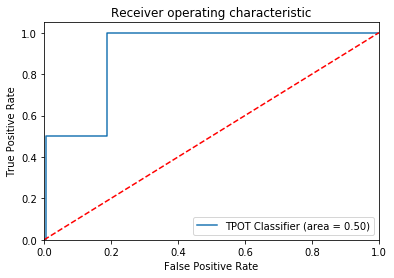

In [92]:
# Print ROC AUC Curve

logit_roc_auc = roc_auc_score(y_test, LogReg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, LogReg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='TPOT Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# TPOT

In [27]:
# Define pipeline with TPOT classifier
tpot_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', TPOTClassifier(generations=3, verbosity=2, max_time_mins=30, n_jobs = -1))])

In [28]:
# Fit the defined pipeline on X_train, y_train
tpot_pipeline.fit(X_train, y_train)
print(tpot_pipeline.score(X_test, y_test))

Generation 1 - Current best internal CV score: 0.9972448679671426
Generation 2 - Current best internal CV score: 0.9972448679671426
Generation 3 - Current best internal CV score: 0.9976385687545442

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=True, criterion=gini, max_features=0.45, min_samples_leaf=1, min_samples_split=5, n_estimators=100)
0.9944954128440368


In [30]:
print(tpot_pipeline.score(X_test, y_test))

0.9944954128440368


In [44]:
#TPOT_Fit_pipeline=tpot_pipeline.fitted_pipeline_
#TPOT_Fit_pipeline

Fit_pipeline= RandomForestClassifier(bootstrap=True, criterion="gini", max_features=0.45, 
                                           min_samples_leaf=1, min_samples_split=5, n_estimators=100)
Fit_pipeline

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=0.45,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [35]:
# TPOT score on x01_test, y01_test
#print(tpot.score(X_test, y_test))
print(tpot_pipeline.score(X_test, y_test))

0.9944954128440368


In [36]:
# Make Predictions
#y_pred_TPOT=TPOT_Fit_pipeline.predict(X_test)
#y_pred_TPOT

#y_pred_TPOT=tpot.predict(X_test)
y_pred_TPOT=tpot_pipeline.predict(X_test)
y_pred_TPOT

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [38]:
# Make Confusion Matrix to compare results against actuals
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_TPOT)
cnf_matrix  

array([[1083,    5],
       [   1,    1]], dtype=int64)

In [39]:
# # Get Accuracy Scores - y01_test vs y01_pred_TPOT
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_TPOT))
print("Precision:",metrics.precision_score(y_test, y_pred_TPOT))
print("Recall:",metrics.recall_score(y_test, y_pred_TPOT))
print("f1 score: ", f1_score(y_test, y_pred_TPOT))

Accuracy: 0.9944954128440368
Precision: 0.16666666666666666
Recall: 0.5
f1 score:  0.25


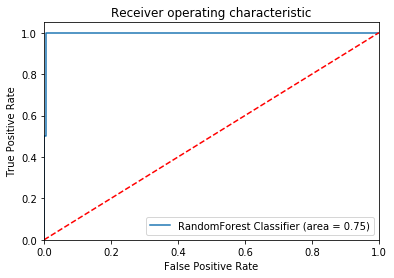

In [40]:
# Print ROC AUC Curve 
 
TPOT_roc_auc = roc_auc_score(y_test, tpot_pipeline.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, tpot_pipeline.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='RandomForest Classifier (area = %0.2f)' % TPOT_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()